In [175]:
#imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import shap 
import lime
import torch
from sentence_transformers import SentenceTransformer as st
import sklearn as sk
import imblearn



In [176]:
# load the data
anno_claims_df = pd.read_csv('data/anno_claims.csv')
pd.set_option('display.max_columns', None)


In [177]:
# load the sentence transformer model
st_model = st("all-MiniLM-L6-v2")


In [178]:
# view the first few rows of the dataframe
anno_claims_df.head()


SettlementValue                             AccidentType Injury_Prognosis  \
0            520.0                                 Rear end      E. 5 months   
1            870.0                                 Rear end      B. 2 months   
2           2140.0       Other side pulled out of side road      G. 7 months   
3            520.0  Rear end - Clt pushed into next vehicle      D. 4 months   
4            260.0                                 Rear end      C. 3 months   

   SpecialHealthExpenses  SpecialReduction  SpecialOverage  GeneralRest  \
0                    0.0               0.0             0.0          0.0   
1                    0.0               0.0             0.0        520.0   
2                    0.0               0.0             0.0       1400.0   
3                    0.0               0.0             0.0          0.0   
4                    0.0               0.0             0.0          0.0   

   SpecialAdditionalInjury  SpecialEarningsLoss  SpecialUsageLoss  \
0                      0.0                  0.0               0.0   
1                      0.0                  0.0              90.0   
2                      0.0                  0.0               0.0   
3                      0.0                  0.0               0.0   
4                      0.0                  0.0               0.0   

   SpecialMedications  SpecialAssetDamage  SpecialRehabilitation  \
0                 0.0                 0.0                    0.0   
1                 0.0                 0.0                    0.0   
2                 0.0                 0.0                    0.0   
3                 0.0                 0.0                    0.0   
4                 0.0                 0.0                    0.0   

   SpecialFixes  GeneralFixed  GeneralUplift  SpecialLoanerVehicle  \
0           0.0         520.0            0.0                   0.0   
1           0.0         260.0            0.0                   0.0   
2           0.0         840.0            0.0                   0.0   
3           0.0         520.0            0.0                   0.0   
4           0.0         260.0            0.0                   0.0   

   SpecialTripCosts  SpecialJourneyExpenses  SpecialTherapy  \
0               0.0                     0.0             0.0   
1               0.0                     0.0             0.0   
2               0.0                     0.0             0.0   
3               0.0                     0.0             0.0   
4               0.0                     0.0             0.0   

  Exceptional_Circumstances Minor_Psychological_Injury Dominant injury  \
0                        No                        Yes            Arms   
1                        No                        Yes        Multiple   
2                        No                         No            Legs   
3                        No                        Yes            Arms   
4                        No                        Yes            Arms   

  Whiplash Vehicle Type Weather Conditions               Accident Date  \
0      Yes   Motorcycle              Rainy  2023-11-10 11:22:24.508901   
1      Yes   Motorcycle              Snowy  2023-06-25 00:55:01.140228   
2      Yes   Motorcycle              Sunny  2020-02-23 17:43:47.805561   
3      Yes        Truck              Rainy  2021-10-02 04:36:32.118423   
4       No   Motorcycle              Rainy  2023-04-02 05:13:07.117423   

                   Claim Date  Vehicle Age  Driver Age  Number of Passengers  \
0  2024-06-11 11:22:24.508901         13.0        33.0                   4.0   
1  2024-01-09 00:55:01.140228          4.0        45.0                   2.0   
2  2020-03-01 17:43:47.805561          9.0        45.0                   4.0   
3  2021-10-13 04:36:32.118423          5.0        62.0                   1.0   
4  2023-04-14 05:13:07.117423          9.0        78.0                   1.0   

                 Accident Description            Injury Description  \
0  Si

In [179]:
#view min/max of the data
anno_claims_df.describe()

SettlementValue  SpecialHealthExpenses  SpecialReduction  \
count      4894.000000            4870.000000            4879.0   
mean       1218.010685               3.611704               0.0   
std         858.866309              85.047845               0.0   
min         240.000000               0.000000               0.0   
25%         669.140000               0.000000               0.0   
50%         988.000000               0.000000               0.0   
75%        1510.000000               0.000000               0.0   
max        7862.900000            3024.000000               0.0   

       SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
count     4883.000000  4872.000000              4866.000000   
mean        13.363580   463.305386                 0.283580   
std         84.223612   766.187669                12.988075   
min          0.000000     0.000000                 0.000000   
25%          0.000000     0.000000                 0.000000   
50%          0.000000     0.000000                 0.000000   
75%          0.000000   906.000000                 0.000000   
max       1250.000000  3912.640000               889.000000   

       SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
count          4872.000000       4870.000000         4870.000000   
mean             52.191115          9.108830            0.109698   
std             392.909130         65.505181            1.389916   
min               0.000000          0.000000            0.000000   
25%               0.000000          0.000000            0.000000   
50%               0.000000          0.000000            0.000000   
75%               0.000000          0.000000            0.000000   
max            7735.580000       1050.000000           30.250000   

       SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
count         4889.000000            4884.000000   4879.000000   4879.000000   
mean            33.460761               0.019697      3.942209    687.509736   
std            282.692529               0.628008    116.335053    399.361279   
min              0.000000               0.000000      0.000000    240.000000   
25%              0.000000               0.000000      0.000000    495.000000   
50%              0.000000               0.000000      0.000000    520.000000   
75%              0.000000               0.000000      0.000000    895.000000   
max           6070.000000              21.200000   4000.000000   4345.000000   

       GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
count    4863.000000           4861.000000       4885.000000   
mean       10.407465              7.719720          1.959881   
std        50.165743            141.155658         13.117419   
min         0.000000              0.000000          0.000000   
25%         0.000000              0.000000          0.000000   
50%         0.000000              0.000000          0.000000   
75%         0.000000              0.000000          0.000000   
max      1430.000000           4408.160000        254.200000   

       SpecialJourneyExpenses  SpecialTherapy  Vehicle Age   Driver Age  \
count             4853.000000     4868.000000  4874.000000  4871.000000   
mean                11.639120      183.600286     9.508617    48.789160   
std                 49.086924      223.885780     5.727625    17.819725   
min                  0.000000        0.000000     0.000000    18.000000   
25%                  0.000000        0.000000     4.000000    33.000000   
50%                  0.000000       50.000000    10.000000    49.000000   
75%                  0.000000      350.000000    14.000000    64.000000   
max                880.000000     1225.000000    19.000000    79.000000   

       Number of Passengers  
count           4878.000000  
mean               2.482370  
std                1.109911  
min                1.000000  
25%                1.000000  
50%                2.000000  
75%                3.000000  
max     

In [180]:
#print all columns in the dataframe
print(anno_claims_df.columns)
print(len(anno_claims_df.columns))

Index(['SettlementValue', 'AccidentType', 'Injury_Prognosis',
       'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
       'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
       'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
       'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
       'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
       'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances',
       'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
       'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Claim Date',
       'Vehicle Age', 'Driver Age', 'Number of Passengers',
       'Accident Description', 'Injury Description', 'Police Report Filed',
       'Witness Present', 'Gender'],
      dtype='object')
36


# Creating Helper Functions
These are useful for easily tranforming a sentence or column into embedded strings, capturing meaning behind words instead of just using a numerical value for the "category".

In [181]:

def encode_text(text):
    return st_model.encode(text, convert_to_tensor=True)


def transform_columns_to_embeddings(df, column_name):

    ids_to_string = {} # integer: string
    string_ids = {} # string: integer

    unique_column_values = df[column_name].unique()
    for index, value in enumerate(unique_column_values):
        if isinstance(value, str):
            string_ids[value] = index
            ids_to_string[index] = value
        else:
            print(f"Skipping non-string value: {value}")


    # Check if the column exists in the DataFrame
    embeddings = {} # hash(value): [embedding]
    strings = {} # hash(value): string
    if column_name not in df.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")

    # Iterate through the DataFrame and encode the specified column
    unique_column_values = df[column_name].unique()
    for value in unique_column_values:
        if isinstance(value, str):  # Ensure the value is a string before encoding
            embedding = encode_text(value)

            ## convert embedding to an array of floats
            embedding = np.array(embedding.cpu()).astype(np.float32).tolist()

            embeddings[hash(value)] = embedding
            strings[hash(value)] = value
        else:
            print(f"Skipping non-string value: {value}")


    df_returns = df.copy()
    ## Convert the column to string indexes
    df_returns[column_name] = df_returns[column_name].apply(lambda x: string_ids.get(x, x))  # Use the string_ids mapping to convert to indexes

    return df_returns, embeddings, strings, ids_to_string

## Example usage
# anno_claims_df, embeddings, strings = transform_columns_to_embeddings(anno_claims_df, 'AccidentType')
# for key, value in embeddings.items():
#     print(f"Key: {key}, String: {strings[key]}")
#     print(f"Embedding shape: {value.shape}")
#     print(f"Embedding: {value}")
#     print("-----")

# Processing Data


## Pre-Pre-Processing
This is where the pre-processing for the pre-processing happens. This includes refactoring the dataframe for analysis regarding pre-processing, for example dropping rows without SettlementValues and refactoring Exceptional_Circumstances to a binary True/False instead of a linguistic Yes/no.

In [182]:
## drop any rows in the 'SettlementValue' column that are null as they will not be useful for our analysis and imputing them would ultimately be pointless if the modle is used to predict such values.
anno_claims_df = anno_claims_df.dropna(subset=['SettlementValue'])

Yes_No_Columns = ['Exceptional_Circumstances', 'Minor_Psychological_Injury', 'Whiplash', 'Police Report Filed', 'Witness Present']

## replace Yes/No with True/False in the Yes_No columns
for col in Yes_No_Columns:
    anno_claims_df[col] = anno_claims_df[col].replace({'Yes': 1.0, 'No': 0.0})
    # anno_claims_df[col] = anno_claims_df[col].astype('Int64')  # Convert to integer type

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2995675385.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  anno_claims_df[col] = anno_claims_df[col].replace({'Yes': 1.0, 'No': 0.0})


In [183]:
## embedding the categorical columns and converting them to hash values for easy retrieval of embeddings
Categorical_Columns = ['AccidentType', 'Dominant injury', 'Vehicle Type', 'Weather Conditions', 'Accident Description', 'Injury Description']

all_embeddings = {}
all_embedded_strings = {}
all_ids_to_string = {}
## convert the categorical columns to their hash values and embeddings
for col in Categorical_Columns:
    anno_claims_df, embeddings, strings, id_to_string = transform_columns_to_embeddings(anno_claims_df, col)

    all_embeddings.update(embeddings)
    all_embedded_strings.update(strings)

    if col not in all_ids_to_string:
        all_ids_to_string[col] = id_to_string
    else:
        all_ids_to_string[col].update(id_to_string)


    ## convert the column float values to their Int64 representation
    # anno_claims_df[col] = anno_claims_df[col].astype('Int64')  # Convert to integer type

Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan


C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\3136765047.py:32: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  embedding = np.array(embedding.cpu()).astype(np.float32).tolist()


Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan
Skipping non-string value: nan


In [184]:
anno_claims_df

SettlementValue  AccidentType Injury_Prognosis  SpecialHealthExpenses  \
0              520.00           0.0      E. 5 months                    0.0   
1              870.00           0.0      B. 2 months                    0.0   
2             2140.00           1.0      G. 7 months                    0.0   
3              520.00           2.0      D. 4 months                    0.0   
4              260.00           0.0      C. 3 months                    0.0   
...               ...           ...              ...                    ...   
4995           275.00           8.0       A. 1 month                    0.0   
4996          1074.35           1.0      H. 8 months                    0.0   
4997          2020.00           1.0      F. 6 months                    0.0   
4998           781.20          11.0      D. 4 months                    0.0   
4999          1390.00           0.0     K. 11 months                    0.0   

      SpecialReduction  SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
0                  0.0             0.0          0.0                      0.0   
1                  0.0             0.0        520.0                      0.0   
2                  0.0             0.0       1400.0                      0.0   
3                  0.0             0.0          0.0                      0.0   
4                  0.0             0.0          0.0                      0.0   
...                ...             ...          ...                      ...   
4995               0.0             0.0          0.0                      0.0   
4996               0.0             0.0          0.0                      0.0   
4997               0.0             0.0       2020.0                      0.0   
4998               0.0             0.0          0.0                      0.0   
4999               0.0             0.0       2300.0                      0.0   

      SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
0                     0.0               0.0                 0.0   
1                     0.0              90.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
...                   ...               ...                 ...   
4995                  0.0               0.0                 0.0   
4996                  0.0               0.0                 0.0   
4997                  0.0               0.0                 0.0   
4998                  0.0               0.0                 0.0   
4999                  0.0               0.0                 0.0   

      SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
0                    0.0                    0.0           0.0         520.0   
1                    0.0                    0.0           0.0         260.0   
2                    0.0                    0.0           0.0         840.0   
3                    0.0                    0.0           0.0         520.0   
4                    0.0                    0.0           0.0         260.0   
...                  ...                    ...           ...           ...   
4995                60.0                    0.0           0.0         260.0   
4996                 0.0                    0.0           0.0         895.0   
4997                 0.0                    0.0           0.0         520.0   
4998                 0.0                    0.0           0.0         520.0   
4999                 0.0                    0.0           0.0        1390.0   

      GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
0               0.0                   0.0               0.0   
1               0.0                   0.0               0.0   
2               0.0                   0.0               0.0   
3               0.0                   0.0               0.0   
4               0.0        

In [185]:
# convet 'Gender' column to numeric values
gender_mapping = {}

def map_genders(df, column_name):
    df_cpy = df.copy()

    mapped_gender = {}
    unique_values = df_cpy[column_name].unique()
    ##remove any null values from the unique values
    unique_values = unique_values[~pd.isnull(unique_values)]
    for i, value in enumerate(unique_values):
        mapped_gender[i] = value
        df_cpy[column_name] = df_cpy[column_name].replace(value, i)
    return mapped_gender, df_cpy

gender_mapping, anno_claims_df = map_genders(anno_claims_df, 'Gender')

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\1962620089.py:13: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cpy[column_name] = df_cpy[column_name].replace(value, i)


In [186]:
# convert 'Accident Date' column into separate columns holding the day of the year (x/365) and seconds since start of the day (00:00:00)
def convert_to_seconds(df, column_name):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if column_name not in df_cpy.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # duplicate the column to avoid overwriting the original data
    df_cpy[column_name + '_time'] = df_cpy[column_name]
    # convert the original column to the day of the year (x/365)
    df_cpy[column_name] = pd.to_datetime(df_cpy[column_name], errors='coerce').dt.dayofyear
    # convert the time to seconds since start of the day (00:00:00)
    df_cpy[column_name + '_time'] = pd.to_datetime(df_cpy[column_name + '_time'], errors='coerce')
    df_cpy[column_name + '_time'] = df_cpy[column_name + '_time'].apply(
        lambda x: (x.hour * 3600 + x.minute * 60 + x.second) if pd.notnull(x) else 0
    )

    # convert the column to a float type
    df_cpy[column_name + '_time'] = df_cpy[column_name + '_time'].astype(float)

    return df_cpy


# convert the 'Claim Date' column into the difference between the col1 and col2. col1 and col2 are both datetime columns, and i would like the result to return two columns, one with the number of days between and one with the seconds between
# the two dates. The function should also handle any null values in the columns and return 0 for the difference if either date is null.
def convert_to_seconds_diff(df, col1, col2):
    df_cpy = df.copy()
    # Check if the columns exist in the DataFrame
    if col1 not in df_cpy.columns or col2 not in df_cpy.columns:
        raise ValueError(f"Columns '{col1}' or '{col2}' do not exist in the DataFrame.")

    # convert the columns to datetime
    df_cpy[col1] = pd.to_datetime(df_cpy[col1], errors='coerce')
    df_cpy[col2] = pd.to_datetime(df_cpy[col2], errors='coerce')

    # calculate the difference between the two columns
    df_cpy['days_diff'] = (df_cpy[col2] - df_cpy[col1]).dt.days.fillna(0).astype(int)

    # seconds_diff should be time from the start of the day (00:00:00)
    df_cpy['seconds_diff'] = df_cpy[col2].apply(
        lambda x: (x.hour * 3600 + x.minute * 60 + x.second) if pd.notnull(x) else 0
    )

    return df_cpy['days_diff'], df_cpy['seconds_diff']


anno_claims_df['Claim_Delay'], anno_claims_df['Claim_Delay_Time'] = convert_to_seconds_diff(anno_claims_df, 'Accident Date', 'Claim Date')  
# drop claim date as it is no longer relevant as more meaningful data has been created from it
anno_claims_df = anno_claims_df.drop(columns=['Claim Date'])

anno_claims_df = convert_to_seconds(anno_claims_df, 'Accident Date')

In [187]:
anno_claims_df

SettlementValue  AccidentType Injury_Prognosis  SpecialHealthExpenses  \
0              520.00           0.0      E. 5 months                    0.0   
1              870.00           0.0      B. 2 months                    0.0   
2             2140.00           1.0      G. 7 months                    0.0   
3              520.00           2.0      D. 4 months                    0.0   
4              260.00           0.0      C. 3 months                    0.0   
...               ...           ...              ...                    ...   
4995           275.00           8.0       A. 1 month                    0.0   
4996          1074.35           1.0      H. 8 months                    0.0   
4997          2020.00           1.0      F. 6 months                    0.0   
4998           781.20          11.0      D. 4 months                    0.0   
4999          1390.00           0.0     K. 11 months                    0.0   

      SpecialReduction  SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
0                  0.0             0.0          0.0                      0.0   
1                  0.0             0.0        520.0                      0.0   
2                  0.0             0.0       1400.0                      0.0   
3                  0.0             0.0          0.0                      0.0   
4                  0.0             0.0          0.0                      0.0   
...                ...             ...          ...                      ...   
4995               0.0             0.0          0.0                      0.0   
4996               0.0             0.0          0.0                      0.0   
4997               0.0             0.0       2020.0                      0.0   
4998               0.0             0.0          0.0                      0.0   
4999               0.0             0.0       2300.0                      0.0   

      SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
0                     0.0               0.0                 0.0   
1                     0.0              90.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
...                   ...               ...                 ...   
4995                  0.0               0.0                 0.0   
4996                  0.0               0.0                 0.0   
4997                  0.0               0.0                 0.0   
4998                  0.0               0.0                 0.0   
4999                  0.0               0.0                 0.0   

      SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
0                    0.0                    0.0           0.0         520.0   
1                    0.0                    0.0           0.0         260.0   
2                    0.0                    0.0           0.0         840.0   
3                    0.0                    0.0           0.0         520.0   
4                    0.0                    0.0           0.0         260.0   
...                  ...                    ...           ...           ...   
4995                60.0                    0.0           0.0         260.0   
4996                 0.0                    0.0           0.0         895.0   
4997                 0.0                    0.0           0.0         520.0   
4998                 0.0                    0.0           0.0         520.0   
4999                 0.0                    0.0           0.0        1390.0   

      GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
0               0.0                   0.0               0.0   
1               0.0                   0.0               0.0   
2               0.0                   0.0               0.0   
3               0.0                   0.0               0.0   
4               0.0        

In [188]:
def fix_prognosis(df, column_name):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if column_name not in df_cpy.columns:
        raise ValueError(f"Column '{column_name}' does not exist in the DataFrame.")
    
    # convert extract the month from the column (D. 4 months) -> 4
    df_cpy[column_name] = df_cpy[column_name].str.extract(r'(\d+)')[0].astype(float)
    # convert the column to numeric values
    df_cpy[column_name] = pd.to_numeric(df_cpy[column_name], errors='coerce')


    return df_cpy

# fix the prognosis column to be numeric values
anno_claims_df = fix_prognosis(anno_claims_df, 'Injury_Prognosis')

In [189]:
## print types of the columns
anno_claims_df.dtypes

SettlementValue               float64
AccidentType                  float64
Injury_Prognosis              float64
SpecialHealthExpenses         float64
SpecialReduction              float64
SpecialOverage                float64
GeneralRest                   float64
SpecialAdditionalInjury       float64
SpecialEarningsLoss           float64
SpecialUsageLoss              float64
SpecialMedications            float64
SpecialAssetDamage            float64
SpecialRehabilitation         float64
SpecialFixes                  float64
GeneralFixed                  float64
GeneralUplift                 float64
SpecialLoanerVehicle          float64
SpecialTripCosts              float64
SpecialJourneyExpenses        float64
SpecialTherapy                float64
Exceptional_Circumstances     float64
Minor_Psychological_Injury    float64
Dominant injury               float64
Whiplash                      float64
Vehicle Type                  float64
Weather Conditions            float64
Accident Dat

## Pre-Processing
This is where the data is imputed and duplicated to create more examples for training against different low-seen examples.

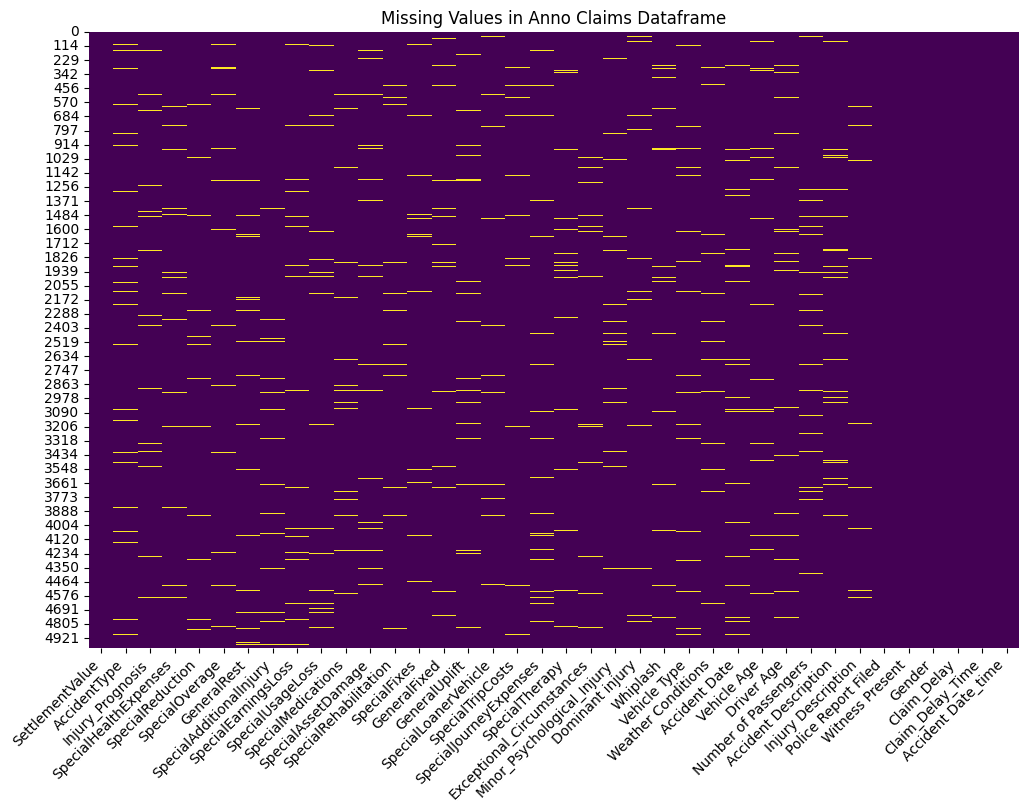

In [190]:
## seaborn heatmap of the missing values in the dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(anno_claims_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Anno Claims Dataframe')
##xticks at 45 degree angle
plt.xticks(rotation=45, ha='right')
plt.show()

In [191]:
anno_claims_df

SettlementValue  AccidentType  Injury_Prognosis  SpecialHealthExpenses  \
0              520.00           0.0               5.0                    0.0   
1              870.00           0.0               2.0                    0.0   
2             2140.00           1.0               7.0                    0.0   
3              520.00           2.0               4.0                    0.0   
4              260.00           0.0               3.0                    0.0   
...               ...           ...               ...                    ...   
4995           275.00           8.0               1.0                    0.0   
4996          1074.35           1.0               8.0                    0.0   
4997          2020.00           1.0               6.0                    0.0   
4998           781.20          11.0               4.0                    0.0   
4999          1390.00           0.0              11.0                    0.0   

      SpecialReduction  SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
0                  0.0             0.0          0.0                      0.0   
1                  0.0             0.0        520.0                      0.0   
2                  0.0             0.0       1400.0                      0.0   
3                  0.0             0.0          0.0                      0.0   
4                  0.0             0.0          0.0                      0.0   
...                ...             ...          ...                      ...   
4995               0.0             0.0          0.0                      0.0   
4996               0.0             0.0          0.0                      0.0   
4997               0.0             0.0       2020.0                      0.0   
4998               0.0             0.0          0.0                      0.0   
4999               0.0             0.0       2300.0                      0.0   

      SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
0                     0.0               0.0                 0.0   
1                     0.0              90.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
...                   ...               ...                 ...   
4995                  0.0               0.0                 0.0   
4996                  0.0               0.0                 0.0   
4997                  0.0               0.0                 0.0   
4998                  0.0               0.0                 0.0   
4999                  0.0               0.0                 0.0   

      SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
0                    0.0                    0.0           0.0         520.0   
1                    0.0                    0.0           0.0         260.0   
2                    0.0                    0.0           0.0         840.0   
3                    0.0                    0.0           0.0         520.0   
4                    0.0                    0.0           0.0         260.0   
...                  ...                    ...           ...           ...   
4995                60.0                    0.0           0.0         260.0   
4996                 0.0                    0.0           0.0         895.0   
4997                 0.0                    0.0           0.0         520.0   
4998                 0.0                    0.0           0.0         520.0   
4999                 0.0                    0.0           0.0        1390.0   

      GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
0               0.0                   0.0               0.0   
1               0.0                   0.0               0.0   
2               0.0                   0.0               0.0   
3               0.0                   0.0               0.0   
4              

In [192]:
test_headder = 'SettlementValue'

# [
#     'SettlementValue', 'AccidentType', 'Injury_Prognosis',
#     'SpecialHealthExpenses', 'SpecialReduction', 'SpecialOverage',
#     'GeneralRest', 'SpecialAdditionalInjury', 'SpecialEarningsLoss',
#     'SpecialUsageLoss', 'SpecialMedications', 'SpecialAssetDamage',
#     'SpecialRehabilitation', 'SpecialFixes', 'GeneralFixed',
#     'GeneralUplift', 'SpecialLoanerVehicle', 'SpecialTripCosts',
#     'SpecialJourneyExpenses', 'SpecialTherapy', 'Exceptional_Circumstances',
#     'Minor_Psychological_Injury', 'Dominant injury', 'Whiplash',
#     'Vehicle Type', 'Weather Conditions', 'Accident Date', 'Vehicle Age',
#     'Driver Age', 'Number of Passengers', 'Accident Description',
#     'Injury Description', 'Police Report Filed', 'Witness Present',
#     'Gender', 'Claim_Delay', 'Claim_Delay_Time', 'Accident Date_time'
# ]

impution_dic = { ## used to store which header needs to be imputed and which do not.
    'needed': [
        'AccidentType',
        'GeneralFixed',
        'Minor_Psychological_Injury',
        'Dominant injury',
        'Whiplash',
        'Weather Conditions',
        'Accident Description',
    ],
    'not_needed': [ ## these are columns which are no input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason.
        'Injury_Prognosis', ## should be defaulted to Z. 0 months
        'SpecialHealthExpenses', ## should be defaulted to 0.0 as not everyone has health expenses
        'SpecialReduction', ## should be defaulted to 0.0 as not everyone has reduction
        'SpecialOverage', ## should be defaulted to 0.0 as not everyone has overage
        'GeneralRest', ## should be defaulted to 0.0 as not everyone has rest
        'SpecialAdditionalInjury', ## should be defaulted to 0.0 as not everyone has additional injury
        'SpecialEarningsLoss', ## should be defaulted to 0.0 as not everyone has earnings loss
        'SpecialUsageLoss', ## should be defaulted to 0.0 as not everyone has usage loss
        'SpecialMedications', ## should be defaulted to 0.0 as not everyone has medications
        'SpecialAssetDamage', ## should be defaulted to 0.0 as not everyone has asset damage
        'SpecialRehabilitation', ## should be defaulted to 0.0 as not everyone has rehabilitation
        'SpecialFixes', ## should be defaulted to 0.0 as not everyone has fixes
        'GeneralUplift', ## should be defaulted to 0.0 as not everyone has uplift
        'SpecialLoanerVehicle', ## should be defaulted to 0.0 as not everyone has loaner vehicle
        'SpecialTripCosts', ## should be defaulted to 0.0 as not everyone has trip costs
        'SpecialJourneyExpenses', ## should be defaulted to 0.0 as not everyone has journey expenses
        'SpecialTherapy', ## should be defaulted to 0.0 as not everyone has therapy
        'Exceptional_Circumstances', ## should be defaulted to False as not everyone has exceptional circumstances
        'Number of Passengers', ## should be defaulted to 0 as not everyone has passengers
        'Injury Description', ## No input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason.
        'Police Report Filed', ## No input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason.
        'Witness Present', ## No input could be used as a form of imput; meaning they are not applicable to the situation and were left blank for a reason
    ],
    'drop': { ## these are columns which should be droppped if they are null as their values are highly correlated with the settlement value
        'SettlementValue',
        'Vehicle Age',
        'Vehicle Type',
        'Driver Age',
        'Accident Date',
        'Claim Date',
    }
}

In [193]:
print(anno_claims_df.dtypes)

SettlementValue               float64
AccidentType                  float64
Injury_Prognosis              float64
SpecialHealthExpenses         float64
SpecialReduction              float64
SpecialOverage                float64
GeneralRest                   float64
SpecialAdditionalInjury       float64
SpecialEarningsLoss           float64
SpecialUsageLoss              float64
SpecialMedications            float64
SpecialAssetDamage            float64
SpecialRehabilitation         float64
SpecialFixes                  float64
GeneralFixed                  float64
GeneralUplift                 float64
SpecialLoanerVehicle          float64
SpecialTripCosts              float64
SpecialJourneyExpenses        float64
SpecialTherapy                float64
Exceptional_Circumstances     float64
Minor_Psychological_Injury    float64
Dominant injury               float64
Whiplash                      float64
Vehicle Type                  float64
Weather Conditions            float64
Accident Dat

In [194]:
def impute_column_with_mlp(df, target_col):


    df_cpy = df.copy()
    
    if target_col not in df_cpy.columns:
        return df

    clean = df_cpy.dropna()
    # drop the tareget column from the dataframe
    Y = clean[target_col]
    X = clean.drop(columns=[target_col])


    ## split the data into train and test sets
    from sklearn.model_selection import train_test_split
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


    # print unique values in the target column
    print("Unique values in target column: ", Y_train.unique())
    print("Unique values in target column: ", len(Y_train.unique()))


    # Create and train the MLP model

    model_params = None
    model_opt = None
    model_compile = None
    callbacks = []
    # Define the model architecture
    if target_col in Yes_No_Columns:
        model_params = tf.keras.layers.Dense(1, activation='sigmoid')

        model_opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        
        # compile docs state the order as (self, optimizer, loss, loss_weights, metrics, ...)
        model_compile = (model_opt, 'binary_crossentropy',['accuracy']) 

        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))


    elif target_col in Categorical_Columns:
        model_params = tf.keras.layers.Dense(len(df[target_col].unique()), activation='softmax')
        

        model_opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        model_compile = (model_opt, 'sparse_categorical_crossentropy',['accuracy'])
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))
        
    else:
        model_params = tf.keras.layers.Dense(1, activation='linear')
        model_opt = tf.keras.optimizers.Adam(learning_rate=0.01)
        model_compile = (model_opt, 'mean_squared_error', ['mean_absolute_error'])
        callbacks.append(tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True))
        

    # classes = clean[target_col].astype(int).unique()
    # print("types of dataframe: ", clean[target_col].dtype)
    # ##remove nan values from the classes
    # print("Classes: ", classes)
    # print("Classes: ", len(classes))
    # weights = sk.utils.class_weight.compute_class_weight(class_weight='balanced', classes=classes, y=clean[target_col])
    # class_weights = dict(zip(classes, weights))
    # print("Class Weights: ", class_weights)


    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        model_params
        
    ])
    model.compile(optimizer=model_compile[0], loss=model_compile[1], metrics=model_compile[2])


    model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_split=0.2, verbose=1, callbacks=callbacks) #, class_weight=class_weights

    ## print the mse and mae of the model using keras

    print("X_train: ", X_train)
    print("Y_train: ", Y_train)

    X_pred = model.predict(X_test)

    if target_col in Categorical_Columns:
        X_pred = np.argmax(X_pred, axis=1)


    print("Y Test: ", Y_test)
    print("X Pred: ", X_pred)

    mse = tf.keras.metrics.MSE(Y_test, X_pred)
    mae = tf.keras.metrics.MAE(Y_test, X_pred)
    print(f'MSE: {mse}, MAE: {mae}')


    # # Impute missing values in the target column using the trained model
    for index, row in df_cpy.iterrows():
        if not pd.isnull(row[target_col]):
            continue

        ## set the row's target column to predicted value
        pred = model.predict(row.drop(target_col).values.reshape(1, -1))


        print("Row: ", row)
        print("Pred: ", pred)
        print("======")

        df_cpy.at[index, target_col] = np.argmax(pred, axis=1)
    return df_cpy

def impute_data(df, dic):
    df_cpy = df.copy()

    ## clean the data by dropping any rows with null values 


    ### loop through the columns and drop rows with null values
    for col in dic['drop']:
        if col not in df_cpy.columns:
            continue
        ## check if the column exists in the DataFrame
        if df_cpy[col].isnull().sum() > 0: 
            df_cpy = df_cpy.dropna(subset=[col])


    ## loop # rough the not needed columns and im# te them manually, treating null values in a float as 0.0, n# l binary values as False, integer as 0
    for col in dic['not_needed']:
        # col in df_cpy.columns:
        # check if the colu#  exists in the DataFrame
        if df_cpy[col].isnull().sum() == 0:  # Only impute if there are null values
            continue
        if col not in df_cpy.columns:
            continue

        if df_cpy[col].dtype == 'float64':
            df_cpy[col] = df_cpy[col].fillna(0.0)
        elif df_cpy[col].dtype == 'int32':
            df_cpy[col] = df_cpy[col].fillna(0)
        elif df_cpy[col].dtype == 'bool':
            df_cpy[col] = df_cpy[col].fillna(False)
        else:
            print(f"Column '{col}' has an unsupported data type for imputation.")

    for col in dic['needed']:
        if col not in df_cpy.columns:
            continue
        # ## loop through the needed columns and impute them with the trained imputing MLP model
        # Check if the column exists in the DataFrame
        if df_cpy[col].isnull().sum() == 0:  # Only impute if there are null values
            continue

        df_cpy = impute_column_with_mlp(df_cpy, col)

    
    return df_cpy

tmp_df = impute_data(anno_claims_df, impution_dic)

##print all column types in the dataframe
# print(anno_claims_df.dtypes)


Unique values in target column:  [ 0.  7.  6.  1. 10.  2.  5.  9. 11. 12.  8. 13.  3. 14. 16. 18. 17. 15.]
Unique values in target column:  18
Epoch 1/100
162/162 [==============================] - 1s 2ms/step - loss: 425.7509 - accuracy: 0.4544 - val_loss: 2.0474 - val_accuracy: 0.5178
Epoch 2/100
162/162 [==============================] - 0s 1ms/step - loss: 3.1364 - accuracy: 0.5254 - val_loss: 1.8744 - val_accuracy: 0.5178
Epoch 3/100
162/162 [==============================] - 0s 1ms/step - loss: 2.0058 - accuracy: 0.5293 - val_loss: 1.8467 - val_accuracy: 0.5194
Epoch 4/100
162/162 [==============================] - 0s 1ms/step - loss: 1.8839 - accuracy: 0.5277 - val_loss: 1.8410 - val_accuracy: 0.5194
Epoch 5/100
162/162 [==============================] - 0s 1ms/step - loss: 2.0550 - accuracy: 0.5273 - val_loss: 1.8368 - val_accuracy: 0.5194
Epoch 6/100
162/162 [==============================] - 0s 1ms/step - loss: 1.8026 - accuracy: 0.5293 - val_loss: 1.8348 - val_accuracy: 0.51

In [195]:
# print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
# print("TensorFlow version:", tf.__version__)
# tf.config.list_physical_devices()
tmp_df

## print unique values in Accident Description column
print(tmp_df['Accident Description'].unique())

[0. 1. 2. 3. 4.]


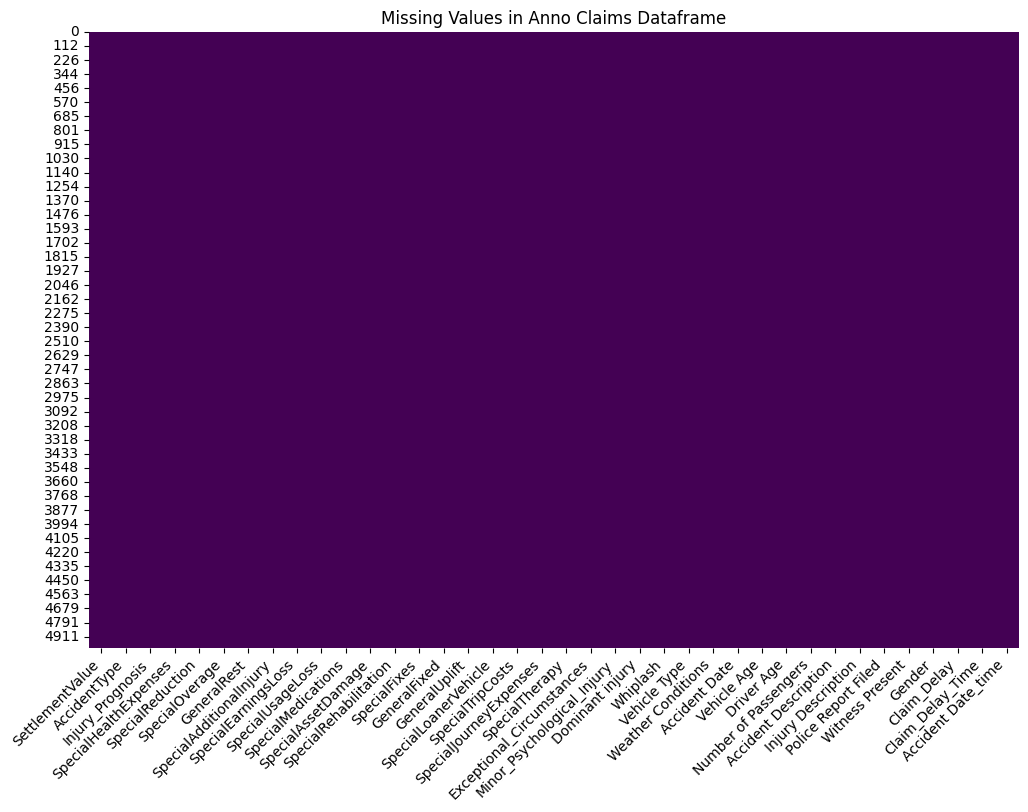

In [196]:
tmp_df

## seaborn heatmap of the missing values in the dataframe
plt.figure(figsize=(12, 8))
sns.heatmap(tmp_df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values in Anno Claims Dataframe')
##xticks at 45 degree angle
plt.xticks(rotation=45, ha='right')
plt.show()

In [197]:
def extract_embeddings(df, column, all_strings, all_embeddings, all_string_ids):
    
    None


In [198]:
tmp_df

SettlementValue  AccidentType  Injury_Prognosis  SpecialHealthExpenses  \
0               520.0           0.0               5.0                    0.0   
1               870.0           0.0               2.0                    0.0   
2              2140.0           1.0               7.0                    0.0   
3               520.0           2.0               4.0                    0.0   
4               260.0           0.0               3.0                    0.0   
...               ...           ...               ...                    ...   
4994            725.0           0.0               4.0                    0.0   
4995            275.0           8.0               1.0                    0.0   
4997           2020.0           1.0               6.0                    0.0   
4998            781.2          11.0               4.0                    0.0   
4999           1390.0           0.0              11.0                    0.0   

      SpecialReduction  SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
0                  0.0             0.0          0.0                      0.0   
1                  0.0             0.0        520.0                      0.0   
2                  0.0             0.0       1400.0                      0.0   
3                  0.0             0.0          0.0                      0.0   
4                  0.0             0.0          0.0                      0.0   
...                ...             ...          ...                      ...   
4994               0.0             0.0        524.0                      0.0   
4995               0.0             0.0          0.0                      0.0   
4997               0.0             0.0       2020.0                      0.0   
4998               0.0             0.0          0.0                      0.0   
4999               0.0             0.0       2300.0                      0.0   

      SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
0                     0.0               0.0                 0.0   
1                     0.0              90.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
...                   ...               ...                 ...   
4994                  0.0               0.0                 0.0   
4995                  0.0               0.0                 0.0   
4997                  0.0               0.0                 0.0   
4998                  0.0               0.0                 0.0   
4999                  0.0               0.0                 0.0   

      SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
0                    0.0                    0.0           0.0         520.0   
1                    0.0                    0.0           0.0         260.0   
2                    0.0                    0.0           0.0         840.0   
3                    0.0                    0.0           0.0         520.0   
4                    0.0                    0.0           0.0         260.0   
...                  ...                    ...           ...           ...   
4994                 0.0                    0.0           0.0         520.0   
4995                60.0                    0.0           0.0         260.0   
4997                 0.0                    0.0           0.0         520.0   
4998                 0.0                    0.0           0.0         520.0   
4999                 0.0                    0.0           0.0        1390.0   

      GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
0               0.0                   0.0               0.0   
1               0.0                   0.0               0.0   
2               0.0                   0.0               0.0   
3               0.0                   0.0               0.0   
4              

In [201]:
def refactor_model(df, categorical_columns, all_embeddings, all_string_ids):
    for col in categorical_columns:
        if col not in df.columns:
            print(f"Column '{col}' not found in DataFrame. Skipping...")
            continue
        print(f"Processing column: {col}")
        # Check if the column exists in the DataFrame
        category_strings = all_string_ids[col]
        print(f"Category strings: {category_strings}")
        category_embeddings = {}
        for key, value in category_strings.items():
            category_embeddings[key] = all_embeddings[hash(value)]
        print(f"Category embeddings: {category_embeddings}")

        print(category_embeddings)
        print(category_strings)


        # iterate through the column, add index imbeddings to the dataframe
        for index, row in df.iterrows():
            # Check if the value exists in the category_strings mapping
            if row[col] in category_strings.keys():
                # Get the corresponding embedding
                embedding = category_embeddings.get(row[col])
                if embedding is not None:
                    # Add the embedding to the DataFrame as new columns
                    for i, val in enumerate(embedding):
                        df.at[index, f"{col}_embedding_{i}"] = val
                else:
                    print(f"Embedding not found for value: {row[col]}")
            else:
                print(f"Value '{row[col]}' not found in category strings.")
        # Drop the original column after processing
        df = df.drop(columns=[col])





    return df, category_embeddings

refactored_df, category_embeddings = refactor_model(tmp_df, Categorical_Columns, all_embeddings, all_ids_to_string)
refactored_df


Processing column: AccidentType
Category strings: {0: 'Rear end', 1: 'Other side pulled out of side road', 2: 'Rear end - Clt pushed into next vehicle', 3: 'Other side pulled on to roundabout', 5: "Other side reversed into Clt's vehicle", 6: "Other side changed lanes and collided with clt's vehicle", 7: 'Other', 8: "Other side turned across Clt's path", 9: 'Other side drove on wrong side of the road', 10: "Other side changed lanes on a roundabout colliding with clt's vehicle", 11: 'Rear end - 3 car - Clt at front', 12: "Other side reversed into clt's stationary vehicle", 13: "Other side collided with Clt's parked vehicle", 14: "Other side pulled from parked position into the path of clt's vehicle", 15: "Other side opened their door, hitting clt's vehicle", 16: 'Other side overtook and hit Clt when pulling in', 17: 'Other side overtook and pulled in too soon', 18: 'Other side overtook whilst clt was turning right'}
Category embeddings: {0: [-0.015040448866784573, 0.028970718383789062, -

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Dominant injury
Category strings: {0: 'Arms', 1: 'Multiple', 2: 'Legs', 3: 'Hips'}
Category embeddings: {0: [-0.03610928729176521, 0.08386962860822678, 0.05500528961420059, 0.022648895159363747, -0.05986315757036209, -0.018726639449596405, 0.14199364185333252, -0.011732677929103374, 0.04613695293664932, -0.03399636596441269, 0.035391684621572495, -0.05226527899503708, 0.030923087149858475, -0.013035222887992859, 0.04645562544465065, -0.04226188734173775, -0.010395923629403114, 0.0011555018136277795, -0.03784237802028656, 0.09573397040367126, -0.06038855388760567, 0.07739384472370148, -0.009774996899068356, 0.010336372070014477, 0.012009624391794205, -0.007865787483751774, -0.05055912584066391, -0.007304157596081495, 0.03424619510769844, -0.13055303692817688, 0.02382124960422516, -0.03691667318344116, -0.07405001670122147, -0.007152136880904436, -0.031159162521362305, 0.020270930603146553, 0.07148667424917221, -0.0014213910326361656, -0.03888177126646042, -0.034432776

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Vehicle Type
Category strings: {0: 'Motorcycle', 1: 'Truck', 2: 'Car'}
Category embeddings: {0: [-0.03587690740823746, 0.12517747282981873, -0.04449477046728134, 0.0040394277311861515, -0.02837318927049637, -0.041190728545188904, 0.10263276845216751, 0.04815999045968056, 0.050300922244787216, -0.0212680846452713, 0.09682464599609375, 0.06000323221087456, 0.10105343908071518, 0.033101361244916916, -0.0325201079249382, 0.007669524755328894, 0.05601675435900688, -0.008991042152047157, -0.008133416064083576, 0.006624139845371246, -0.0216257032006979, 0.11322515457868576, 0.03847236558794975, 0.054447077214717865, -0.04328431934118271, 0.029963191598653793, -0.030787134543061256, 0.08278928697109222, -0.08811217546463013, -0.0951303020119667, -0.016021613031625748, 0.018830325454473495, -0.0796126127243042, 0.017099808901548386, -0.07312217354774475, -0.05912090465426445, -0.04249812662601471, 0.06651490181684494, 0.07126978039741516, -0.06313588470220566, -0.018821200355

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Weather Conditions
Category strings: {0: 'Rainy', 1: 'Snowy', 2: 'Sunny'}
Category embeddings: {0: [0.01730426773428917, -0.021530847996473312, 0.05018426850438118, 0.08962979912757874, 0.0015685203252360225, 0.0020195588003844023, 0.16329017281532288, -0.08176545053720474, 0.0374407023191452, 0.028852734714746475, -0.02341102622449398, -0.09602784365415573, 0.0487724132835865, 0.011838764883577824, -0.024598293006420135, -0.000631103350315243, -0.04712158069014549, -0.06403852254152298, -0.04092107713222504, -0.04331010580062866, -0.06765642762184143, 0.01218984555453062, -0.0825832262635231, 0.0033290861174464226, 0.0436592735350132, 0.034265514463186264, 0.026379436254501343, 0.03449832275509834, -0.03133272007107735, -0.10698755830526352, 0.015000347048044205, 0.06145700067281723, 0.029164263978600502, -0.08923154324293137, -0.022887926548719406, -0.021371515467762947, 0.032378923147916794, -0.022146906703710556, -0.006968943867832422, -0.01002869475632906, -0.00

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Accident Description
Category strings: {0: 'Side collision at an intersection.', 1: 'Lost control on a snowy road.', 2: 'Hit a deer on the highway.', 3: 'Swerved to avoid another vehicle.', 4: 'Rear-ended at a stoplight.'}
Category embeddings: {0: [0.08125966787338257, 0.044401444494724274, -0.017631981521844864, 0.045366354286670685, 0.007338601630181074, -0.0275250431150198, 0.07112794369459152, 0.06305615603923798, -0.02761055901646614, 0.008237529546022415, 0.04030969738960266, 0.00979636237025261, -0.008239559829235077, 0.02760375663638115, -0.06742680817842484, -0.001267377519980073, -0.0581989623606205, -0.02315598540008068, -0.07086121290922165, 0.07992411404848099, -0.08403085172176361, -0.034757692366838455, -0.022480452433228493, 0.013906522653996944, -0.06795744597911835, 0.03227533400058746, 0.05417001619935036, 0.05440575256943703, -0.01460192445665598, -0.026484966278076172, 0.02256087400019169, -0.07561395317316055, -0.02968175895512104, 0.02433386817

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

Processing column: Injury Description
Category strings: {0: 'Whiplash and minor bruises.', 1: 'Minor cuts and scrapes.', 2: 'Concussion and bruised ribs.', 3: 'Fractured arm and leg.', 4: 'Sprained ankle and wrist.'}
Category embeddings: {0: [-0.006770663429051638, 0.07045157998800278, 0.04476665332913399, 0.11477179080247879, 0.040262654423713684, 0.03385022655129433, 0.011292620562016964, 0.02985742874443531, 0.02815135195851326, 0.020021716132760048, 0.059926047921180725, -0.010905739851295948, -0.040974486619234085, 0.0757325142621994, -0.06013050302863121, -0.07069338858127594, 0.0801139771938324, -0.014387599192559719, -0.05516142025589943, 0.03586024418473244, -0.05154445767402649, 0.05118096247315407, 0.01161329448223114, 0.04546906054019928, -0.07650955021381378, 0.06299930810928345, 0.0012099837185814977, 0.029863733798265457, 0.027063870802521706, -0.06058920547366142, -0.04351393133401871, -0.04936867579817772, -0.03926597908139229, -0.02618441730737686, -0.0230399537831544

C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.at[index, f"{col}_embedding_{i}"] = val
C:\Users\Spoon\AppData\Local\Temp\ipykernel_4380\2054461053.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider

SettlementValue  Injury_Prognosis  SpecialHealthExpenses  \
0               520.0               5.0                    0.0   
1               870.0               2.0                    0.0   
2              2140.0               7.0                    0.0   
3               520.0               4.0                    0.0   
4               260.0               3.0                    0.0   
...               ...               ...                    ...   
4994            725.0               4.0                    0.0   
4995            275.0               1.0                    0.0   
4997           2020.0               6.0                    0.0   
4998            781.2               4.0                    0.0   
4999           1390.0              11.0                    0.0   

      SpecialReduction  SpecialOverage  GeneralRest  SpecialAdditionalInjury  \
0                  0.0             0.0          0.0                      0.0   
1                  0.0             0.0        520.0                      0.0   
2                  0.0             0.0       1400.0                      0.0   
3                  0.0             0.0          0.0                      0.0   
4                  0.0             0.0          0.0                      0.0   
...                ...             ...          ...                      ...   
4994               0.0             0.0        524.0                      0.0   
4995               0.0             0.0          0.0                      0.0   
4997               0.0             0.0       2020.0                      0.0   
4998               0.0             0.0          0.0                      0.0   
4999               0.0             0.0       2300.0                      0.0   

      SpecialEarningsLoss  SpecialUsageLoss  SpecialMedications  \
0                     0.0               0.0                 0.0   
1                     0.0              90.0                 0.0   
2                     0.0               0.0                 0.0   
3                     0.0               0.0                 0.0   
4                     0.0               0.0                 0.0   
...                   ...               ...                 ...   
4994                  0.0               0.0                 0.0   
4995                  0.0               0.0                 0.0   
4997                  0.0               0.0                 0.0   
4998                  0.0               0.0                 0.0   
4999                  0.0               0.0                 0.0   

      SpecialAssetDamage  SpecialRehabilitation  SpecialFixes  GeneralFixed  \
0                    0.0                    0.0           0.0         520.0   
1                    0.0                    0.0           0.0         260.0   
2                    0.0                    0.0           0.0         840.0   
3                    0.0                    0.0           0.0         520.0   
4                    0.0                    0.0           0.0         260.0   
...                  ...                    ...           ...           ...   
4994                 0.0                    0.0           0.0         520.0   
4995                60.0                    0.0           0.0         260.0   
4997                 0.0                    0.0           0.0         520.0   
4998                 0.0                    0.0           0.0         520.0   
4999                 0.0                    0.0           0.0        1390.0   

      GeneralUplift  SpecialLoanerVehicle  SpecialTripCosts  \
0               0.0                   0.0               0.0   
1               0.0                   0.0               0.0   
2               0.0                   0.0               0.0   
3               0.0                   0.0               0.0   
4               0.0                   0.0               0.0   
...             ...                   ...               ...   
4994            0.0                   0.0               0

In [ ]:
def train_model(df, target_col):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if target_col not in df_cpy.columns:
        raise ValueError(f"Column '{target_col}' does not exist in the DataFrame.")
    
    # drop the tareget column from the dataframe
    Y = df_cpy[target_col]
    X = df_cpy.drop(columns=[target_col])


    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(512, activation='relu', input_shape=(X.shape[1],)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, activation='linear')
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss='mean_absolute_error', metrics=['mean_squared_error', 'mean_absolute_error', 'mean_absolute_percentage_error'])

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='mean_absolute_percentage_error', patience=100, restore_best_weights=True)
    model.fit(X, Y, epochs=1000, batch_size=32, validation_split=0.2, verbose=1, callbacks=[early_stopping]) # 

    return model

In [206]:

from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(refactored_df, test_size=0.2, random_state=42)

model = train_model(train_df, 'SettlementValue')

Epoch 1/1000
143/143 [==============================] - 3s 13ms/step - loss: 646.6097 - mean_squared_error: 1030810.7500 - mean_absolute_error: 646.6097 - mean_absolute_percentage_error: 63.5610 - val_loss: 255.2272 - val_mean_squared_error: 160804.8750 - val_mean_absolute_error: 255.2272 - val_mean_absolute_percentage_error: 22.9157
Epoch 2/1000
143/143 [==============================] - 1s 9ms/step - loss: 402.0666 - mean_squared_error: 386331.7188 - mean_absolute_error: 402.0666 - mean_absolute_percentage_error: 37.1302 - val_loss: 246.0602 - val_mean_squared_error: 158099.7188 - val_mean_absolute_error: 246.0602 - val_mean_absolute_percentage_error: 21.8922
Epoch 3/1000
143/143 [==============================] - 1s 9ms/step - loss: 378.0108 - mean_squared_error: 307979.0000 - mean_absolute_error: 378.0108 - mean_absolute_percentage_error: 35.3945 - val_loss: 396.1163 - val_mean_squared_error: 319348.1875 - val_mean_absolute_error: 396.1163 - val_mean_absolute_percentage_error: 31.1

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_57 (Dense)            (None, 512)               19456     
                                                                 
 dropout_40 (Dropout)        (None, 512)               0         
                                                                 
 dense_58 (Dense)            (None, 256)               131328    
                                                                 
 dropout_41 (Dropout)        (None, 256)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               32896     
                                                                 
 dropout_42 (Dropout)        (None, 128)               0         
                                                                 
 dense_60 (Dense)            (None, 64)              

28/28 [==============================] - 0s 1000us/step - loss: 479987.7812 - mean_squared_error: 479987.7812
Test MSE: 479987.78125
Test Loss: 479987.78125


In [204]:
def test_settlement_value(model, df, target_col):
    df_cpy = df.copy()
    # Check if the column exists in the DataFrame
    if target_col not in df_cpy.columns:
        raise ValueError(f"Column '{target_col}' does not exist in the DataFrame.")

    X = df_cpy.drop(columns=[target_col])

    predictions = model.predict(X)
    return predictions

In [ ]:
predictions = test_settlement_value(model, test_df, 'SettlementValue')
print("Predictions: ", predictions)
print("Y: ", test_df['SettlementValue'])



## score the model using mean absolute error and mean squared error from keras
mse = tf.keras.metrics.MSE(predictions, test_df['SettlementValue'])
mae = tf.keras.metrics.MAE(predictions, test_df['SettlementValue'])
mape = tf.keras.metrics.MAPE(predictions, test_df['SettlementValue'])

print("Average MSE: ", np.mean(mse))
print("Average MAE: ", np.mean(mae))
print("Average MAPE: ", np.mean(mape))

28/28 [==============================] - 0s 2ms/step
Predictions:  [[1220.3656 ]
 [1050.8083 ]
 [ 563.465  ]
 [1350.7406 ]
 [1202.839  ]
 [ 490.92487]
 [ 268.3757 ]
 [ 532.53174]
 [1237.2622 ]
 [1204.2007 ]
 [ 523.52997]
 [ 571.94   ]
 [1208.8522 ]
 [ 720.9109 ]
 [ 371.04156]
 [ 484.7714 ]
 [ 183.17131]
 [ 813.756  ]
 [ 791.3617 ]
 [ 725.04047]
 [ 310.45108]
 [ 569.4444 ]
 [ 661.4595 ]
 [1340.7733 ]
 [ 665.9587 ]
 [1219.3463 ]
 [ 309.12982]
 [ 627.66754]
 [ 766.7876 ]
 [ 788.6391 ]
 [ 326.47287]
 [ 738.2497 ]
 [ 502.2574 ]
 [ 367.60242]
 [ 285.82764]
 [ 400.08725]
 [ 518.9573 ]
 [ 759.5078 ]
 [ 461.86014]
 [ 726.1379 ]
 [ 902.6723 ]
 [1021.3739 ]
 [ 566.1164 ]
 [ 257.7794 ]
 [ 848.42267]
 [1527.2842 ]
 [ 542.45166]
 [ 992.2479 ]
 [ 163.94934]
 [1070.1067 ]
 [ 519.4328 ]
 [ 348.56   ]
 [1014.0936 ]
 [ 356.10956]
 [ 916.2404 ]
 [ 723.11224]
 [ 614.7303 ]
 [ 724.5775 ]
 [ 464.65445]
 [1015.2714 ]
 [ 321.85574]
 [ 483.90707]
 [ 653.1103 ]
 [ 303.2461 ]
 [ 453.24582]
 [ 388.93054]
 [ 719.85

In [ ]:
def predict_settlement_value(model, data):

    # Check if the data is a DataFrame or a single row
    if isinstance(data, pd.DataFrame):
        # If it's a DataFrame, use the model to predict on the entire DataFrame
        predictions = model.predict(data)
    else:
        # If it's a single row, reshape it to match the input shape of the model
        predictions = model.predict(np.array(data).reshape(1, -1))

    return predictions